## IBM Quantum Challenge Fall 2021
# Challenge 4c: Battery revenue optimization with adiabatic quantum computation

*Challenge solution write-up by Lukas Botsch*

The solution I present in this notebook might not be the most optimized and highest scoring one submitted during the challenge (the final score is just over 300k). But I want to give some background and try to explain how and why the implemented solution works, from the perspective of a physicist. I'm by no means an expert in qiskit! In fact, this was the first time I seriously played around with the framework ;)

If you are only interested in the code, please skip to the [end of the notebook](#final)

# Content
* [Very short introduction to the computational model](#intro)
* [Adiabatic Quantum Computation](#adiabatic_computation)
* [Battery revenue optimization problem](#problem)
* [Solving the Relaxed Battery Revenue Optimization Problem Step by Step](#step_by_step)
* [Optimizing the Solution](#optimizing)
* [Final Solution](#final)


<a id="intro"></a>
# Very short introduction to the quantum circuit computational model

_Let me first give a VERY condensed overview of the computational model._

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_bloch_vector, plot_histogram, plot_bloch_multivector, plot_state_qsphere
import warnings
warnings.filterwarnings("ignore")

## The qubit

In most models of quantum circuit computing (including IBM's), the smallest unit of information is a two-level quantum system, called a *qubit*. The state $\left|\Psi\right\rangle$ of a qubit lives in a two-dimensional Hilbert space $\mathcal{H}_2$. We can define a basis of this Hilbert space, consisting of two orthogonal states. Let's call them $\left|0\right\rangle$ and $\left|1\right\rangle$ in analogy to classical bits. The state of the qubit can then be described (in that basis) as a linear combination of the basis states: $\left|\Psi\right\rangle = \alpha\left|0\right\rangle + \beta \left|1\right\rangle$, where $\alpha, \beta$ are complex numbers and $\sqrt{|\alpha|^2+|\beta|^2} = 1$. We can now describe the state by the two-dimensional column vector

\begin{equation*}
\left|\Psi\right\rangle = \left[
\begin{array}{l} \alpha \\ \beta \end{array}
\right] = e^{i\phi_0}\left[
\begin{array}{l} \cos(\theta/2) \\ e^{i\phi}\sin(\theta/2) \end{array}
\right],
\end{equation*}

where I have rewritten $\alpha,\beta$ in terms of their global phase $\phi_0$, relative phase $\phi$ and their magnitudes $|\alpha| = \cos(\theta/2)$, $|\beta| = \sin(\theta/2)$. As the global phase doesn't have any physical effect on a measurement, we can discard it and we are left with a description of the state using two real angles, $\phi$ and $\theta$. This representation allows us to visualize the state as a point on the unit sphere, the so-called Bloch sphere.

Let's visualize the state $\left|+\right\rangle = \frac{1}{\sqrt{2}}\left[\begin{array}{l} 1 \\ 1 \end{array}\right] = \left[\begin{array}{l}\cos(\pi/4) \\ \sin(\pi/4)\end{array}\right]$

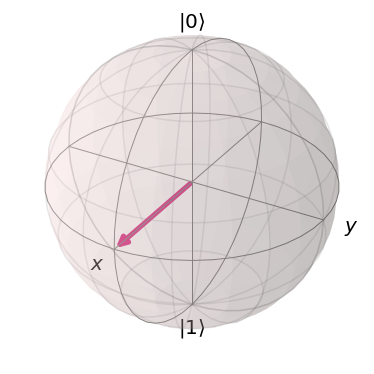

In [2]:
plot_bloch_vector([1, np.pi/2, 0], coord_type='spherical')

To perform computation on a qubit, we need a way to modify its state. This is what (single qubit) gates do. The action of a gate on a single qubit can be described by a 2x2 unitary matrix $U$ and the resulting state can be obtained by matrix multiplication $\left|U\Psi\right\rangle = U\left|\Psi\right\rangle$.

Let's for example take the Pauli-X gate, represented by $X = \left[ \begin{array}{lr} 0 & 1 \\ 1 & 0 \end{array} \right]$. It's action on a state, $\left|X\Psi\right\rangle = X\left|\Psi\right\rangle = \left[ \begin{array}{lr} 0 & 1 \\ 1 & 0 \end{array} \right] \left[ \begin{array}{l} \alpha \\ \beta \end{array} \right] = \left[ \begin{array}{l} \beta \\ \alpha \end{array} \right]$, is to exchange the components of the state vector. The state $\left|0\right\rangle$ becomes $\left|1\right\rangle$ and the state $\left|1\right\rangle$ becomes $\left|0\right\rangle$.

Finally, once we have performed computation on the qubit state, we need to transfer the information to a form that the classical computer understands, to a classical bit. This is done by performing a measurement of the qubit state. The outcome of the measurement will be one of the basis states, namely $\left|0\right\rangle$ with a probability $\left|\left\langle0\right|\left.\Psi\right\rangle\right|^2 = |\alpha|^2$ and $\left|1\right\rangle$ with a probability $\left|\left\langle1\right|\left.\Psi\right\rangle\right|^2 = |\beta|^2$.


## Multi-qubit register

As in a classical computer, we can not do much with just a single qbit. So let us now consider multiple qubits and combine them into a quantum register. The state of a N-qubit register now lives in the $2^N$-dimensional Hilbert space resulting from the tensor product $\mathcal{H} = \otimes_{i=1}^N \mathcal{H}_2 = \mathcal{H}_2 \otimes \mathcal{H}_2 \otimes ... \otimes \mathcal{H}_2$ of the single qubit Hilbert space $\mathcal{H}_2$ and we now need $2^N$ basis states to describe it. For a two qubit register, we can construct a basis with the four states $\left| 00 \right\rangle$, $\left| 01 \right\rangle$, $\left| 10 \right\rangle$, $\left| 11 \right\rangle$ and describe the register state in that basis with a vector
\begin{equation*}
\left| \Psi \right\rangle = \left[ \begin{array}{l} a_{00} \\ a_{01} \\ a_{10} \\ a_{11} \end{array} \right]
\end{equation*}

We can construct register states from the single qubit states by taking their tensor product:
\begin{equation*}
\left| ab \right\rangle = \left| a \right\rangle \otimes \left| b \right\rangle = \left[ \begin{array}{l} a_0b_0 \\ a_0 b_1 \\ a_1b_0 \\ a_1b_1 \end{array} \right]
\end{equation*}
But what about the two-qubit state
\begin{equation*}
\frac{1}{\sqrt{2}}\left( \left|00\right\rangle + \left|11\right\rangle \right) = \frac{1}{\sqrt{2}}\left[ \begin{array}{l} 1 \\ 0 \\ 0 \\ 1 \end{array} \right]\text{ ?}
\end{equation*}
It's a perfectly valid two-qubit state, but we can't construct it as a tensor product of single qubit states (try it)! We call it an entangled state.

As in the single qubit case, multi-qubit gates can be represented by unitary matrices and operate on a register state by matrix multiplication. An N-qubit gate is then represented by a $2^N \times 2^N$ unitary matrix.

Finally, measurement works in the same way as for single qubits: When we measure the two-qubit state $\left| \Psi \right\rangle$ in the basis given above, we will find it in one of the basis states $\left|ij\right\rangle$ with a probability $\left|\left\langle ij \right|\left.\Psi\right\rangle\right|^2 = |a_{ij}|^2$.

## Encoding numbers in qubit registers



When we want to encode an unsigned integer number $a\in\mathbb{N}$ in a classical computer, we encode its binary representation $a = \sum_{i=0}^{N-1} a_i 2^i$ in a bit register $a_N...a_2a_1a_0$. We can do the same thing with quantum registers and represent the number $a$ in an N-qubit register
\begin{equation*}
\left|a\right\rangle = \left|a_N...a_2a_1a_0\right\rangle = \otimes_{i=0}^{N-1} \frac{1}{\sqrt{N}} \left( (1-a_i) \left|0\right\rangle + a_i \left|1\right\rangle \right)
\end{equation*}

<a id="adiabatic_computation"></a>
# Adiabatic Quantum Computation


Adiabatic Quantum Computation (AQC) is a different model of quantum computation. It is based on the adiabatic approximation [**[1]**](https://arxiv.org/abs/1611.04471):

> For a system initially prepared in an eigenstate (e.g., the ground state) $\left|\epsilon_0(0)\right\rangle$ of a time-dependent Hamiltonian $H(t)$, the time evolution governed by the Schrödinger equation $i\frac{\partial\left|\psi(t)\right\rangle}{\partial t} = H(t)\left|\psi(t)\right\rangle$ (we set $\hbar=1$ from now on) will approximately keep the actual state $\left|\psi(t)\right\rangle$ of the system in the corresponding instantaneous ground state (or other eigenstate) $\left|\epsilon_0(t)\right\rangle$ of $H(t)$, provided that $H(t)$ varies “sufficiently slowly”.

Many optimization problems can be translated into a form suitable for AQC. The basic idea is to construct a Hamiltonian $H_f$, whose ground state encodes the solution of the optimization problem. The quantum system is then initialized in the ground state of a simple Hamiltonian $H_0$ and let to evolve adiabatically under a time dependent Hamiltonian $H(t)$, such that $H(0) = H_0$ and $H(t_f) = H_f$. At time $t_f$, the system is in the ground state of Hamiltonian $H_f$, which encodes the solution of the optimization problem.

One way to construct the time dependent Hamiltonian $H(t)$ is by interpolation of the initial ($H_0$) and final ($H_f$) Hamiltonians:
\begin{equation*}
H(t) = \beta(t)H_0 + \gamma(t) H_f,
\end{equation*}
where $\beta(t)$ and $\gamma(t)$ are monotonically decreasing and increasing, respectively, and $\beta(0)=1$, $\beta(t_f)=0$, $\gamma(0)=0$, $\gamma(t_f)=1$.

## Example
Let's see an example: We want to find the solution to the optimization problem
\begin{equation*}
    \min_{x\in\mathcal{X}} f(x), \text{ with }\mathcal{X} = [0, 1, ..., 2^N-1].
\end{equation*}
We construct the Hamiltonian $H_f$, such that $H_f\left|x\right\rangle = f(x)\left|x\right\rangle$, where $\left|x\right\rangle$ is an encoding of $x\in\mathcal{X}$. We define $H_0 = \mathbb{1} - \left|\phi\right\rangle\left\langle\phi\right|$, where $\left|\phi\right\rangle = \frac{1}{\sqrt{N}}\sum_{i=0}^{N-1}\left|i\right\rangle$ is the uniform superposition state.

We initialize the state $\left|\psi\right\rangle$ in the ground state of Hamiltonian $H_0$: $\left|\psi(0)\right\rangle = \left|\phi\right\rangle$ and let it evolve under the time dependent Hamiltonian $H(t) = (1-t/t_f) H_0 + t/t_f H_f$ (assuming the evolution satisfies the adiabatic theorem and is "sufficiently slow"). At time $t_f$, $\left|\psi(t_f)\right\rangle$ is in the ground state of the Hamiltonian $H(t_f) = H_f$ and therefore satisfies
\begin{equation*}
H_f \left|\psi(t_f)\right\rangle = \min_{x\in\mathcal{X}} f(x)\left|\psi(t_f)\right\rangle.
\end{equation*}
The final state $\left|\psi(t_f)\right\rangle$ encodes the solution to the optimization problem!

## Connection to Circuit Model

How can we translate the time evolution to our circuit model and solve the optimization problem using AQC on IBM's quantum computers? After all, we can't construct the time dependent Hamiltonian $H(t)$!

First, let's define $t_i = i \frac{t_f}{p}$ ($i\in[0,1,...,p]$), the discretization of the time window [0, t_f] into $p$ chunks. We can now approximate the time dependent Hamiltonian $H(t)$ by the (p+1) time independent Hamiltonians $H_i = H(t_i)$.

We can express the time evolution of a state $\left|\psi\right\rangle$ under a time independent Hamiltonian $H$ using the unitary time evolution operator $U_H(t) = \exp\left(-iHt\right)$:
\begin{equation*}
\left|\psi(t)\right\rangle = U_H(t)\left|\psi(0)\right\rangle = \exp\left(-iHt\right)\left|\psi(0)\right\rangle.
\end{equation*}

Assuming the Hamiltonian $H_i = H(t_i)$ changes "sufficiently slowly" to $H_{i+1} = H(t_{i+1})$, we can approximate the time evolution of the initial state $\left|\psi(0)\right\rangle$ to the final state $\left|\psi(t_f)\right\rangle$ under the Hamiltonian $H(t)$ as
\begin{equation*}
\left|\psi(t_f)\right\rangle \approx \Pi_{j=1}^p \exp\left(-iH_j (t_j-t_{j-1})\right) \left|\psi(0)\right\rangle = \Pi_{j=1}^p \exp\left(-iH_j \frac{t_f}{p}\right) \left|\psi(0)\right\rangle.
\end{equation*}
If $\left|\psi(0)\right\rangle$ is the ground state of the initial Hamiltonian $H(0)$, then $\left|\psi(t_f)\right\rangle$ is the ground state of the final Hamiltonian $H_f$.


Taking the interpolating time dependent Hamiltonian from above, we get:
\begin{equation*}
\left|\psi(t_f)\right\rangle \approx \Pi_{j=1}^p \exp\left( -i[\beta(t_j)H_0 + \gamma(t_j)H_f] \frac{t_f}{p} \right) \left|\psi(0)\right\rangle
\end{equation*}

Let's rename $H_0 \equiv B$ and $H_f \equiv C$ and define $\beta(t_i) = \frac{p}{t_f}\beta_i$, with $\beta_i = 1-i/p$ and $\gamma(t_i) = \frac{p}{t_f}\gamma_i$, with $\gamma_i = i/p$ ($i\in[1,...,p]$). The above equation becomes
\begin{equation*}
\left|\psi(t_f)\right\rangle \approx \Pi_{j=1}^p \exp\left( -i[\beta_j B + \gamma_j C] \right) \left|\psi(0)\right\rangle = U(B, \beta_p)U(C, \gamma_p)...U(B, \beta_1)U(C, \gamma_1)\left|\psi(0)\right\rangle,
\end{equation*}
where $U(B, \beta) \equiv \exp(-i\beta B)$ and $U(C, \gamma) \equiv \exp(-i\gamma C)$.

We have brought the AQC time evolution operator into a form suitable for the circuit model! Note that $U$, $B$ and $C$ are time independent unitary operators and $\left|\psi(0)\right\rangle$ is the ground state of $B$. One simple choice for the operator $B$ is $B = (\sigma_x)^{\otimes N}$, the tensor product of the Pauli X operator. Depending on the type of optimization problem we want to solve, we can choose $\left|\psi(0)\right\rangle = \left|-\right\rangle^{\otimes N}$ or $\left|\psi(0)\right\rangle = \left|+\right\rangle^{\otimes N}$, the eigenstates of $B$ with the lowest and highest eigenvalue, respectively. In other words the first choice is useful for minimization problems, while the second choice can be used for maximization.

<a id="problem"></a>
# Battery revenue optimization problem


Battery storage systems have provided a solution to flexibly integrate large-scale renewable energy (such as wind and solar) in a power system. The revenues from batteries come from different types of services sold to the grid. The process of energy trading of battery storage assets is as follows: A regulator asks each battery supplier to choose a market in advance for each time window. Then, the batteries operator will charge the battery with renewable energy and release the energy to the grid depending on pre-agreed contracts. The supplier makes therefore forecasts on the return and the number of charge/discharge cycles for each time window to optimize its overall return. 

How to maximize the revenue of battery-based energy storage is a concern of all battery storage investors. Choose to let the battery always supply power to the market which pays the most for every time window might be a simple guess, but in reality, we have to consider many other factors. 

What we can not ignore is the aging of batteries, also known as **degradation**. As the battery charge/discharge cycle progresses, the battery capacity will gradually degrade (the amount of energy a battery can store, or the amount of power it can deliver will permanently reduce). After a number of cycles, the battery will reach the end of its usefulness. Since the performance of a battery decreases while it is used, choosing the best cash return for every time window one after the other, without considering the degradation, does not lead to an optimal return over the lifetime of the battery, i.e. before the number of charge/discharge cycles reached.

Therefore, in order to optimize the revenue of the battery, what we have to do is to select the market for the battery in each time window taking both **the returns on these markets (value)**, based on price forecast, as well as expected battery **degradation over time (cost)** into account ——It sounds like solving a common optimization problem, right?

## Problem Setting

Here, we have referred to the problem setting in de la Grand'rive and Hullo's paper [**[2]**](https://arxiv.org/abs/1908.02210).

Considering two markets $M_{1}$ , $M_{2}$, during every time window (typically a day), the battery operates on one or the other market, for a maximum of $n$ time windows. Every day is considered independent and the intraday optimization is a standalone problem: every morning the battery starts with the same level of power so that we don’t consider charging problems. Forecasts on both markets being available for the $n$ time windows, we assume known for each time window $t$ (day) and for each market:

- the daily returns $\lambda_{1}^{t}$ , $\lambda_{2}^{t}$

- the daily degradation, or health cost (number of cycles), for the battery $c_{1}^{t}$, $c_{2}^{t}$ 

We want to find the optimal schedule, i.e. optimize the life time return with a cost less than $C_{max}$ cycles. We introduce $d = max_{t}\left\{c_{1}^{t}, c_{2}^{t}\right\} $.

We introduce the decision variable $z_{t}, \forall t \in [1, n]$ such that $z_{t} = 0$ if the supplier chooses $M_{1}$ , $z_{t} = 1$ if choose $M_{2}$, with every possible vector $z = [z_{1}, ..., z_{n}]$ being a possible schedule. The previously formulated problem can then be expressed as:


\begin{equation}
\underset{z \in \left\{0,1\right\}^{n}}{max} \displaystyle\sum_{t=1}^{n}(1-z_{t})\lambda_{1}^{t}+z_{t}\lambda_{2}^{t}
\end{equation}
<br>
\begin{equation}
    s.t. \sum_{t=1}^{n}[(1-z_{t})c_{1}^{t}+z_{t}c_{2}^{t}]\leq C_{max}
\end{equation}

## Formulating the relaxed knapsack problem

Here we are making the answer according to the way shown in [**[2]**](https://arxiv.org/abs/1908.02210), which is solving the "relaxed" formulation of knapsack problem.
The relaxed problem can be defined as follows:
\begin{equation*}
\text{maximize } f(z)=return(z)+penalty(z)
\end{equation*}

\begin{equation*}
\text{where} \quad return(z)=\sum_{t=1}^{n} return_{t}(z) \quad \text{with} \quad return_{t}(z) \equiv\left(1-z_{t}\right) \lambda_{1}^{t}+z_{t} \lambda_{2}^{t}
\end{equation*}

\begin{equation*}
\quad \quad \quad \quad \quad \quad penalty(z)=\left\{\begin{array}{ll}
0 & \text{if}\quad  cost(z)<C_{\max } \\
-\alpha\left(cost(z)-C_{\max }\right) & \text{if} \quad cost(z) \geq C_{\max }, \alpha>0 \quad \text{constant}
\end{array}\right.
\end{equation*}

Now, our task is to find an operator C, such that
\begin{equation*}
C\left|z\right\rangle = f(z)\left|z\right\rangle.
\end{equation*}
Applying the AQC procedure introduced earlier, we should find an approximate solution to the relaxed battery optimization problem.

## Simple example

Let's walk through a simple example:

* $\lambda_1 = [1, 3]$
* $\lambda_2 = [2, 8]$
* $C_1 = [1, 1]$
* $C_2 = [3, 5]$
* $C_\text{max} = 6$

The possible schedules are $z_1 = [0, 0], z_2 = [0, 1], z_3 = [1, 0]$ and $z_4 = [1, 1]$,
which we can encode in a two-qubit register. We see that only $z_1, z_2$ and $z_3$ are feasible
schedules, as $cost(z_4) = 8 > C_\text{max}$. We can calculate $f(z_1) = 4, f(z_2) = 9,
f(z_3) = 5, f(z_4) = 2$ and find $z_\text{opt} = z_2$.


In [3]:
L1 = np.asarray([1, 3])
L2 = np.asarray([2, 8])
C1 = np.asarray([1, 1])
C2 = np.asarray([3, 5])
C_max = 6

<a id="step_by_step"></a>
# Solving the Relaxed Battery Revenue Optimization Problem Step by Step


## Simplified problem

To see that the AQC procedure works, let's first try to solve a simplified version of the problem: Let's only consider the return part and assume there is no cost associated to battery degradation.

In that case, the problem reduces to:
\begin{equation*}
\text{maximize } f(z)=return(z) = \sum_{t=1}^n \left((1-z_t)\lambda_1^t + z_t\lambda_2^t\right)
\end{equation*}

## Solving the Simplified Problem with AQC

To solve the simplified maximization problem, we need a qubit register of size N (N is the number of days) to encode the battery schedules. We will choose the operator $B = (\sigma_x)^{\otimes N}$ and the initial state $\left|\psi_0\right\rangle = \left|+\right\rangle^{\otimes N}$.

To implement the operator $U(B, \beta) = \exp(-iB\beta)$, we use the single qubit gate RX, defined by:
\begin{equation*}
\text{RX}(\theta) = \exp\left(-i\frac{\theta}{2}\sigma_x\right),
\end{equation*}
and for the operator $U(C, \gamma)$, we can make use of another single qubit gate, the phase gate:
\begin{equation*}
\text{P}(\lambda) = \left[ \begin{array}{cc} 1 & 0 \\ 0 & e^{i\lambda} \end{array} \right].
\end{equation*}
You should convince yourself that the operator
\begin{equation*}
\otimes_{t=1}^{N} \text{P}\left(-\gamma(\lambda_2^t-\lambda_1^t)\right)
\end{equation*}
is equivalent to $U(C, \gamma)$ up to a global phase, such that $C\left|z\right\rangle = f(z)\left|z\right\rangle$.

Let's implement the AQC scheme in qiskit!

In [4]:
from typing import List, Union
import math, time
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister, assemble, execute, Aer
from qiskit.compiler import transpile
from qiskit.circuit import Gate
from qiskit.circuit.library.standard_gates import *

simulator = Aer.get_backend('aer_simulator')

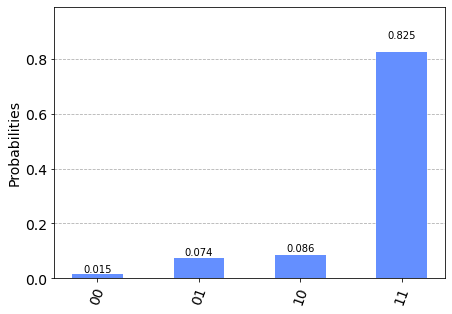

In [5]:
z = QuantumRegister(2)
qc = QuantumCircuit(z)

# Initialize state 
qc.h(z)

# Number of time slices
p = 5

for i in range(p):
    beta = 1-(i+1)/p
    gamma = (i+1)/p

    # U(C, γ)
    for j in range(len(L1)):
        qc.p(-gamma*(L2[j]-L1[j]), z[j])
    
    # U(B, β)
    qc.rx(2*beta, z)

qc.measure_all()
result = simulator.run(qc).result()
plot_histogram(result.get_counts())

We have successfully solved the simplified optimization problem using AQC! The algorithm finds the schedule with the highest return.

**Try to change the number of time slices p!** What happens when p becomes too small? Remember, p controls the "slowness" of the time evolution and has to be large enough, so that the adiabatic approximation still holds. 

## General approach

Let's now solve the original problem, taking into account the cost penalty in our operator $U(C, \gamma)$.
We will construct the the operator in the following steps:

1. return part &#9989;
2. penalty part
    1. Cost calculation (data encoding)
    2. Constraint testing (marking the indices whose data exceed $C_{max}$)
    3. Penalty dephasing (adding penalty to the marked indices)
    4. Reinitialization of constraint testing and cost calculation (clean the data register and flag register)



### 2A. Cost Calculation

In order to build the penalty part of the operator $C$, we first need to calculate the total cost of the state $z$:
\begin{equation*}
\text{cost}(z) = \sum_{t=1}^N (1-z_t)c_1^t + z_t c_2^t
\end{equation*}
We want to encode the total cost in an ancilla register, in order to get the entangled state
\begin{equation*}
\left|\psi\right\rangle = \left|z\right\rangle \otimes \left|cost(z)\right\rangle.
\end{equation*}

But how do we perform addition on a quantum computer?

#### The ripple-carry adder

Let's start by implementing a circuit that uses a technique often found in classical binary arithmatic, the ripple-carry adder.

In [6]:
def ripple_carry_adder(data_qubits: int, const: int) -> QuantumCircuit:
    def add_block(data_qubits: int, k: int) -> QuantumCircuit:
        """ |z> = |z0 z1 ... zn> -> |z+2^k> """
        N = data_qubits
        qr_data = QuantumRegister(data_qubits, "data")
        qr_temp = QuantumRegister(data_qubits-1, "temp")
        qc = QuantumCircuit(qr_data, qr_temp, name=f"const_adder({const})")

        # calculate carry bit
        qc.cx(qr_data[k], qr_temp[0])
        for i in range(N-2-k):
            #print(f"i = {i}, len(qr_data) = {len(qr_data)}, len(qr_temp) = {len(qr_temp)}")
            qc.ccx(qr_data[k+1+i], qr_temp[i], qr_temp[i+1])
        
        # backpropagate carry
        for i in reversed(range(N-2-k)):
            qc.cx(qr_temp[i+1], qr_data[k+2+i])
            qc.ccx(qr_data[k+1+i], qr_temp[i], qr_temp[i+1])
        
        qc.cx(qr_temp[0], qr_data[k+1])
        qc.cx(qr_data[k], qr_temp[0])
        
        
        # flip qbit k
        qc.x(qr_data[k])

        return qc 

    bin_const = [int(x) for x in bin(const)[2:]]

    qr_data = QuantumRegister(data_qubits, "data")
    qr_temp = QuantumRegister(data_qubits-1, "temp")
    qc = QuantumCircuit(qr_data, qr_temp, name=f"const_adder({const})")

    for k, b in enumerate(reversed(bin_const)):
        if b:
            qc.append(add_block(data_qubits, k), qr_data[:] + qr_temp[:])
            qc.barrier()

    return qc


Let's first test the implementation to make sure that the adder works.
We test the addition of two numbers a and b, using the ripple-carry adder circuit we just implemented:

1. Encoding the binary representation of the number a in the initial state of the data register
2. Use the ripple-carry adder circuit to add the number b
3. Measure the state of the data register

In [7]:
def test_ripple_carry_adder(a, b):
    """ Calculate a + b using the ripple-carry adder. """
    
    data_qubits = data_qubits = math.ceil(math.log(a+b, 2)) + 1 if not a+b & (a+b - 1) == 0 else math.ceil(math.log(a+b, 2)) + 2
    qr_data = QuantumRegister(data_qubits, "data")
    qr_temp = QuantumRegister(data_qubits-1, "temp")
    cr_data = ClassicalRegister(data_qubits, "c_data")
    qc = QuantumCircuit(qr_data, qr_temp, cr_data)

    # Step 1: Encode the number a into the qr_data register
    binary_a = bin(a)[2:]
    for i, bit in enumerate(reversed(binary_a)):
        if bit == '1':
            qc.x(qr_data[i])
    
    # Step 2: Add the number b using ripple-carry adder
    qc.append(ripple_carry_adder(data_qubits, b), qr_data[:] + qr_temp[:])
    
    # Step 3: Measure the result
    qc.measure(qr_data, cr_data)
    result = simulator.run(transpile(qc, backend=simulator)).result()
    
    # Make sure the measurement outcome corresponds to the addition a+b
    values = np.asarray([int(v, 2) for v in result.get_counts().keys()])
    counts = np.asarray(list(result.get_counts().values()))
    assert values[np.argmax(counts)] == a+b
    
test_ripple_carry_adder(5, 3)
test_ripple_carry_adder(4, 5)
test_ripple_carry_adder(1, 0)

How does the ripple-carry adder perform addition? Let's draw the circuit that adds the constant 1 to a data register of size 5!

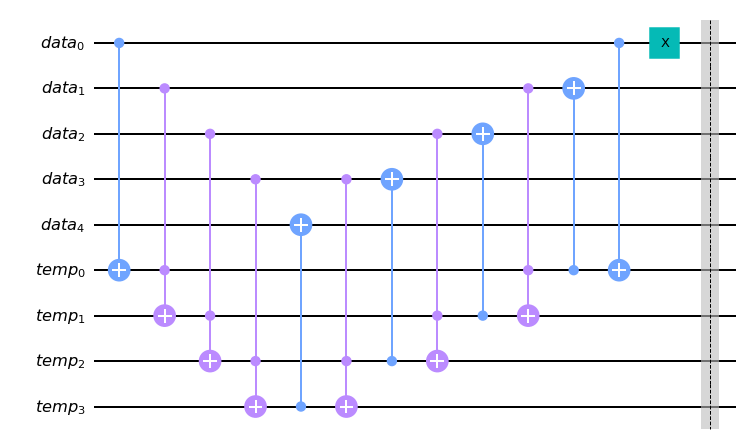

In [8]:
ripple_carry_adder(data_qubits=5, const=1).decompose().draw('mpl')

As we can see, adding the constant 1 already results in a rather complex circuit. We note:

1. The ripple-carry adder needs N-1 ancilla qubits for a data register of size N
2. The carry ripples down (hence the name) from the least significant bit affected by the addition to the most significant bit of the data register into the ancilla register (temp) and back up the data register

#### QFT Adder

While the ripple-carry adder performs addition in the computational basis, the QFT adder [**[3]**](https://arxiv.org/abs/1411.5949) performs addition in the Fourier basis (have a look at the Qiskit textbook [**[4]**](https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html) for a great introduction to the Fourier basis and the Quantum Fourier Transform!). Let's see an implementation

In [9]:
def qft(data_qubits: int, inverse=False) -> QuantumCircuit:
    """Quantum Fourier Transform (https://arxiv.org/pdf/1411.5949.pdf)"""
    qc = QuantumCircuit(data_qubits)

    N = data_qubits-1

    qc.h(N)
    for n in range(1, N+1):
        qc.cp(2*np.pi / 2**(n+1), N-n, N)

    for i in range(1, N):
        qc.h(N-i)
        for n in range(1, N-i+1):
            qc.cp(2*np.pi / 2**(n+1), N-(n+i), N-i)
    qc.h(0)

    # Calculate IQFT
    qc = qc.inverse() if inverse else qc
    return qc


def qft_add(data_qubits: int, const: int) -> QuantumCircuit:
    """QFT Adder (https://arxiv.org/pdf/1411.5949.pdf)"""

    qc = QuantumCircuit(data_qubits)

    N = data_qubits-1

    bin_const = [int(x) for x in bin(const)[2:]] # Big endian
    bin_const = [0]*(N-len(bin_const)) + bin_const

    for n in range(1, N+1):
        if bin_const[n-1]:
            qc.p(2*np.pi / 2**(n+1), N)

    for i in range(1, N+1):
        for n in range(N-i+1):
            if bin_const[n+i-1]:
                qc.p(2*np.pi / 2**(n+1), N-i)

    return qc

def qft_const_adder(data_qubits: int, const: int) -> QuantumCircuit:
    qr_data = QuantumRegister(data_qubits, "data")
    qc = QuantumCircuit(qr_data)
    qc.append(qft(data_qubits), qr_data)
    qc.barrier()
    qc.append(qft_add(data_qubits, const), qr_data)
    qc.barrier()
    qc.append(qft(data_qubits, inverse=True), qr_data)
    qc.barrier()
    
    return qc

In [10]:
def test_qft_adder(a, b):
    """ Calculate a + b using the QFT adder. """
    
    data_qubits = data_qubits = math.ceil(math.log(a+b, 2)) + 1 if not a+b & (a+b - 1) == 0 else math.ceil(math.log(a+b, 2)) + 2
    qr_data = QuantumRegister(data_qubits, "data")
    cr_data = ClassicalRegister(data_qubits, "c_data")
    qc = QuantumCircuit(qr_data, cr_data)

    # Step 1: Encode the number a into the qr_data register
    binary_a = bin(a)[2:]
    for i, bit in enumerate(reversed(binary_a)):
        if bit == '1':
            qc.x(qr_data[i])
    
    # Step 2: Apply Quantum Fourier Transform
    qc.append(qft(data_qubits), qr_data)
    
    # Step 3: Add the number b using QFT adder
    qc.append(qft_add(data_qubits, b), qr_data)
    
    # Step 4: Apply Inverse Fourier Transform
    qc.append(qft(data_qubits, inverse=True), qr_data)
    
    # Step 5: Measure the result
    qc.measure(qr_data, cr_data)
    result = simulator.run(transpile(qc, backend=simulator)).result()
    
    # Make sure the measurement outcome corresponds to the addition a+b
    values = np.asarray([int(v, 2) for v in result.get_counts().keys()])
    counts = np.asarray(list(result.get_counts().values()))
    assert values[np.argmax(counts)] == a+b
    
test_qft_adder(5, 3)
test_qft_adder(4, 5)
test_qft_adder(1, 0)

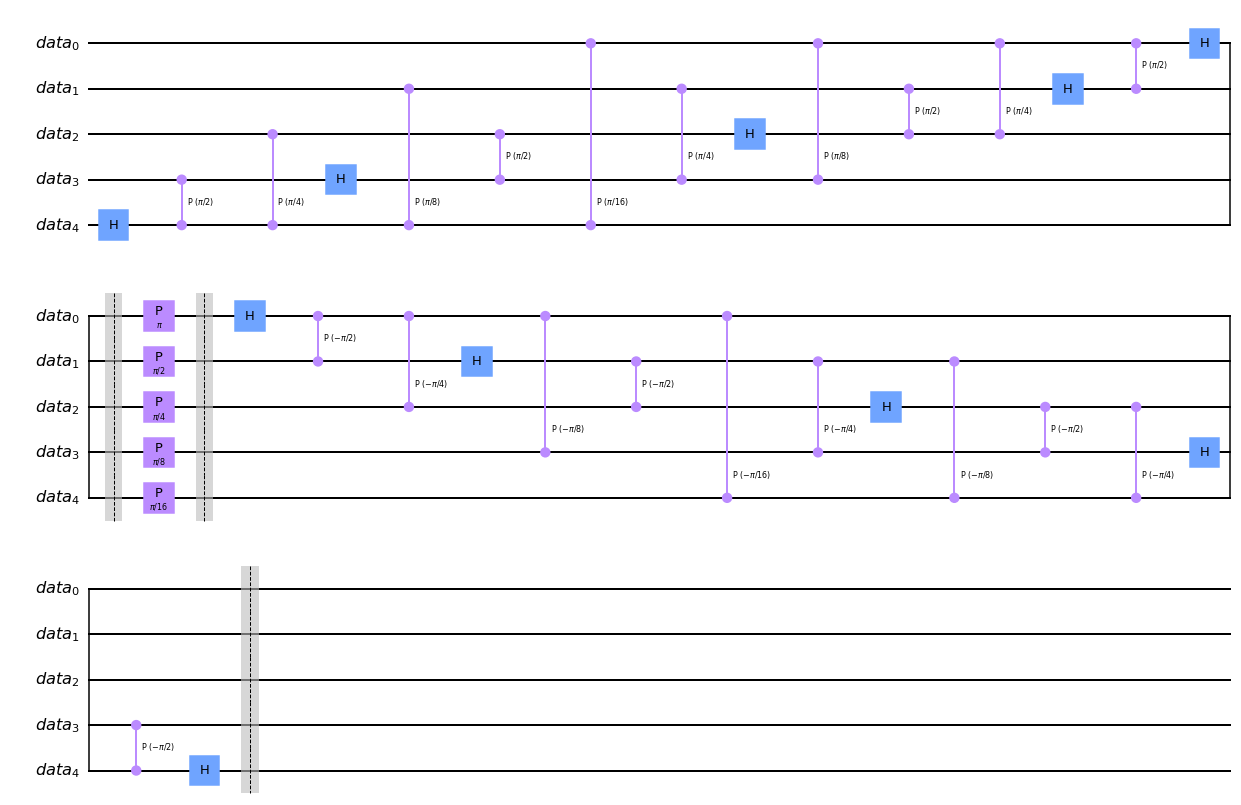

In [11]:
qft_const_adder(data_qubits=5, const=1).decompose().draw('mpl')

As we can see, the QFT adder consists of three stages:
1. First, the Quantum Fourier Transform is applied
2. The add operation is performed
3. The resulting state is transformed back into the computational basis

We see that the overhead of applying transform and its inverse is really large and the final circuit looks much more complex than that of the ripple-carry adder. But the actual adding stage is now much smaller. This can get useful, as we will have to calculate sums with many summands and only have to apply the QFT once at the beginning and its inverse once at the end!

#### The cost_calculation function

We now know two methods to perform an addition on a quantum computer. Let's implement the cost_calculation function:

In [12]:
def cost_calculation(z_qubits: int, cost_qubits: int, C1: list, C2: list) -> QuantumCircuit:
    
    qr_z = QuantumRegister(z_qubits, "z")
    qr_cost = QuantumRegister(cost_qubits, "cost")
    qc = QuantumCircuit(qr_z, qr_cost)

    qc.append(qft(cost_qubits).to_gate(label=" [ QFT ] "), qr_cost)
    for i, (c1, c2) in enumerate(zip(C1, C2)):
        qc.append(qft_add(cost_qubits, c2).to_gate(label=f" [ +{c2} ] ").control(1), [qr_z[i]] + qr_cost[:])
        qc.x(qr_z[i])
        qc.append(qft_add(cost_qubits, c1).to_gate(label=f" [ +{c1} ] ").control(1), [qr_z[i]] + qr_cost[:])
        qc.x(qr_z[i])
    qc.append(qft(cost_qubits, inverse=True).to_gate(label=" [ IQFT ] "), qr_cost)
    
    return qc

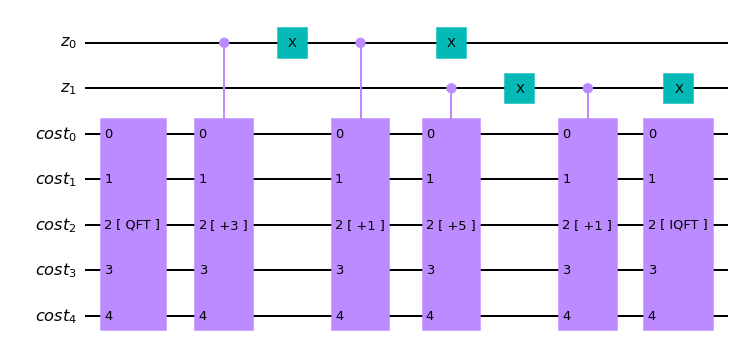

In [13]:
cost_calculation(2, 5, C1, C2).draw("mpl")

We will look at ways to optimize this circuit later.

### 2B. Constraint Testing

Next, we need to test the condition $cost(z) > C_\text{max}$, as we only want to apply the penalty to those states. We add another ancilla qubit to encode the truth value of this condition. Our final state should be the entangled state:
\begin{equation*}
\left|\psi\right\rangle = \left|z\right\rangle \otimes \left|cost(z)\right\rangle \otimes \left|cost(z) > C_\text{max}\right\rangle
\end{equation*}

Let's assume, $C_\text{max} = 2^c$ is a power of 2. Then, the condition is false if and only if
\begin{equation*}
cost(z)_{i} = 0\,\,\, \forall i > c,\text{ where } cost(z) = \sum_{i=0}^{M} 2^i cost(z)_i\text{ is the binary decomposition of }cost(z).
\end{equation*}

But what if $C_\text{max}$ is not a power of 2? Well, we use a trick! The conditions $cost(z) > C_\text{max}$ and $cost(z) + w > C_\text{max} + 2$ are equivalent for any constant $w$, so we can always define $w$, such that $C_\text{max} + w = 2^c$ is a power of 2. Even more, let's assume the quantum register for $cost(z)$ has size $M+1$, and lets set $c = M$. Then, we define $w$, such that $C_\text{max}+w = 2^M-1$. To test the condition $cost(z) > C_\text{max}$, we first check that $C_\text{max} < 2^c$. If not, $cost(z)$ can never get larger than $C_\text{max}$. Otherwise, we simply check if $(cost(z)+w)_{c}$ is 1.

Let's implement the constraint_testing function:


In [14]:
def constraint_testing(cost_qubits: int, C_max: int) -> QuantumCircuit:
    """Test the condition cost(z) > C_max and set a flag F if the condition holds
    true.

    """

    qr_cost = QuantumRegister(cost_qubits, "cost")
    qr_f = QuantumRegister(1, "flag")
    qc = QuantumCircuit(qr_cost, qr_f)

    c = cost_qubits-1
    w = 2**c - C_max - 1

    if w > 0:
        # Add w to cost(z)
        qc.append(qft(cost_qubits), qr_cost)
        qc.append(qft_add(cost_qubits, w), qr_cost)
        qc.append(qft(cost_qubits, inverse=True), qr_cost)
        # Set F if the condition cost(z) > C_max holds
        qc.cx(qr_cost[c], qr_f)

    return qc


### 2C. Penalty Dephasing

Now we have the entangled state
\begin{equation*}
\left|\psi\right\rangle = \left|z\right\rangle \otimes \left|cost(z)\right\rangle \otimes \left|cost(z) > C_\text{max}\right\rangle
\end{equation*}
and we need to construct the penalty part of the operator $U(C, \gamma)$. As in the return part, we will use the phase gate.

Let's first see the implementation of the penalty_dephasing function:


In [15]:
def penalty_dephasing(cost_qubits: int, alpha: float, gamma: float) -> QuantumCircuit:
    """Apply the penalty part of U(C, γ)."""
    
    qr_cost = QuantumRegister(cost_qubits, "cost")
    qr_f = QuantumRegister(1, "flag")
    qc = QuantumCircuit(qr_cost, qr_f)

    # Add phase alpha * (cost(z) + w) to all infeasible states
    for i in range(cost_qubits):
        qc.cp((2**i) * alpha * gamma, qr_f, qr_cost[i])

    # Add phase -alpha * (Cmax + w) = -alpha * 2^(cost_qubits-1) to all
    # infeasible states
    C_max_plus_w = 2**(cost_qubits-1)-1
    qc.p(-C_max_plus_w * alpha * gamma, qr_f)

    return qc


There are quite some things going on here. Some remarks:
1. We apply controlled phase (cp) gates to each qubit in the cost register, controlled by the flag qubit. We are adding a phase $\alpha \gamma 2^i$ to each qubit $i$ in the cost register if both the qubit itself and the control qubit, the flag, are in the state $\left|1\right\rangle$.

2. But how does this affect the z register? After all, thats the register that encodes our schedules and to which we want to apply our operator $U(C, \gamma)$. Remember that our state $\left|z\right\rangle\otimes\left|cost(z)\right\rangle\otimes\left|cost(z)>C_\text{max}\right\rangle$ is entangled. As we saw in the beginning, we can't describe it in terms of single qubit states anymore.

3. The second part is applied with a phase gate on the flag qubit. Remember, that we added the constant $w$ to $cost(z)$ in the previous step. But that's not a big issue: we can simply adjust our penalty function:
    \begin{equation*}
    penalty(z)=\left\{\begin{array}{ll}
    0 & \text{if}\quad  cost(z)<C_{\max } \\
    -\alpha\left((cost(z)+w)-(C_{\max }+w)\right) & \text{if} \quad cost(z) \geq C_{\max }, \alpha>0 \quad \text{constant}
    \end{array}\right.
    \end{equation*}
    By applying the phase gate with a phase $\theta = -\alpha \gamma (C_\text{max}+w)$ to the flag qubit, we add a relative phase $\theta = -\alpha \gamma (C_\text{max}+w)$ only if $cost(z) > C_\text{max}$.

This concludes the penalty part of the $U(C, \gamma)$ operator! Let's see it in action:

1) The initial state is a uniform superposition of all possible schedules


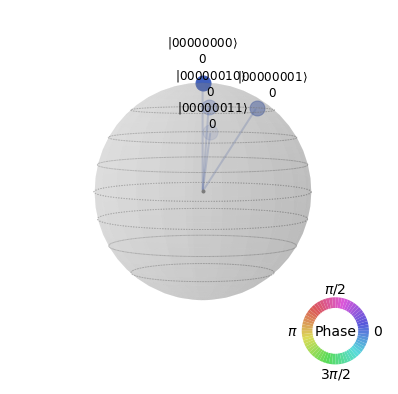

2) After cost calculation, the state represents |z> ⊗ |cost(z)> ⊗ |0>


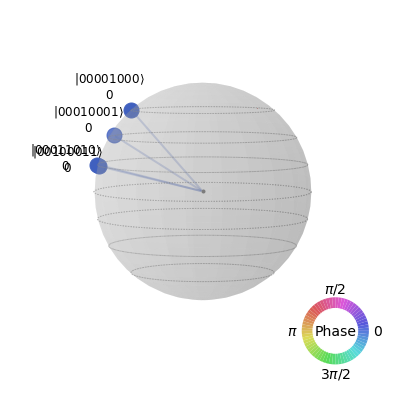

3) After constraint testing, the state represents |z> ⊗ |cost(z)+w> ⊗ |cost(z)>C_max>


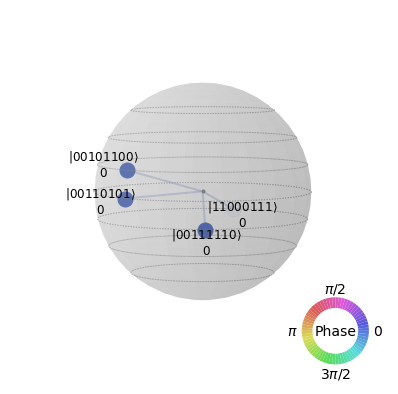

4) After penalty dephasing, the components of the state vector
   |z> ⊗ |cost(z)+w> ⊗ |cost(z)>C_max> corresponding to basis states,
   where the highest order qubit (the flag) is 1 (here |11000111>) gain a relative phase
   θ = cost(z)-C_max. In the simple example with C_max = 6, the only infeasible schedule is z = 11,
   with cost(z) = 8. And, as expected, we see a relative phase θ = 2!


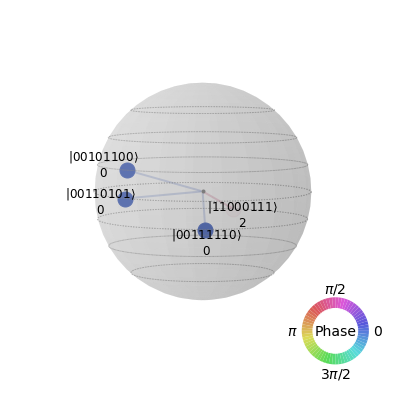

In [16]:
def plot_penalty_dephased_states():
    z_qubits = len(L1)
    # Calculate required size of cost register
    max_c = sum([max(l0, l1) for l0, l1 in zip(C1, C2)])
    cost_qubits = math.ceil(math.log(max_c, 2)) + 1 if not max_c & (max_c - 1) == 0 else math.ceil(math.log(max_c, 2)) + 2

    qr_z = QuantumRegister(z_qubits, name="z")
    qr_cost = QuantumRegister(cost_qubits, name="cost")
    qr_f = QuantumRegister(1, name="flag")
    cr_z = ClassicalRegister(2, name="c_z")
    qc = QuantumCircuit(qr_z, qr_cost, qr_f, cr_z)

    # Initialize z register
    qc.h(qr_z)
    qc.save_statevector(label="state1")

    # Calculate cost(z)
    qc.append(cost_calculation(z_qubits, cost_qubits, C1, C2), qr_z[:] + qr_cost[:])
    qc.save_statevector(label="state2")

    # Test constraint
    qc.append(constraint_testing(cost_qubits, C_max), qr_cost[:] + qr_f[:])
    qc.save_statevector(label="state3")

    # Apply penalty dephasing
    qc.append(penalty_dephasing(cost_qubits, 1.0, 1.0), qr_cost[:] + qr_f[:])
    qc.save_statevector(label="state4")

    # Measure register z
    qc.measure(qr_z, cr_z)

    # Run the circuit
    result = simulator.run(qc.decompose().decompose()).result().results[0].data

    state1 = result.state1
    state2 = result.state2
    state3 = result.state3
    state4 = result.state4

    # Plot the states
    print("1) The initial state is a uniform superposition of all possible schedules")
    display(plot_state_qsphere(state1, show_state_phases=True))
    print("2) After cost calculation, the state represents |z> ⊗ |cost(z)> ⊗ |0>")
    display(plot_state_qsphere(state2, show_state_phases=True))
    print("3) After constraint testing, the state represents |z> ⊗ |cost(z)+w> ⊗ |cost(z)>C_max>")
    display(plot_state_qsphere(state3, show_state_phases=True))
    print("""4) After penalty dephasing, the components of the state vector
   |z> ⊗ |cost(z)+w> ⊗ |cost(z)>C_max> corresponding to basis states,
   where the highest order qubit (the flag) is 1 (here |11000111>) gain a relative phase
   θ = cost(z)-C_max. In the simple example with C_max = 6, the only infeasible schedule is z = 11,
   with cost(z) = 8. And, as expected, we see a relative phase θ = 2!""")
    display(plot_state_qsphere(state4, show_state_phases=True))
plot_penalty_dephased_states()

### 2D. Reinitialization

Before we continue, we need to reset all ancilla qubits to the state $\left|0\right\rangle$, so we can reuse them when we recalculate operator $U(C, \gamma)$ for the next $\gamma$.


In [17]:
def reinitialization(z_qubits: int, cost_qubits: int, C1: list, C2: list, C_max: int) -> QuantumCircuit:
    """Reinitialize the ancilla qubits to |0>."""
    
    qr_z = QuantumRegister(z_qubits, "z")
    qr_cost = QuantumRegister(cost_qubits, "cost")
    qr_f = QuantumRegister(1, "F")
    qc = QuantumCircuit(qr_z, qr_cost, qr_f)

    qc.append(constraint_testing(cost_qubits, C_max, False).inverse().to_gate(label="  Constraint Testing +  "), qr_cost[:] + qr_f[:])
    qc.append(cost_calculation(z_qubits, cost_qubits, C1, C2, False).inverse().to_gate(label="  Cost Calculation +  "), qr_z[:] + qr_cost[:])

    return qc


## Putting it all together

We now have all the parts, let's put them together:

In [18]:
def solver_function(L1: list, L2: list, C1: list, C2: list, C_max: int) -> QuantumCircuit:
    
    # the number of qubits representing answers
    z_qubits = len(L1)
    
    # the maximum possible total cost
    max_c = sum([max(l0, l1) for l0, l1 in zip(C1, C2)])
    
    # the number of qubits representing data values can be defined using the maximum possible total cost as follows:
    cost_qubits = math.ceil(math.log(max_c, 2)) + 1 if not max_c & (max_c - 1) == 0 else math.ceil(math.log(max_c, 2)) + 2
    
    ### U(C, γ) ###
    # 1. return part
    def phase_return(z_qubits: int, gamma: float, L1: list, L2: list, to_gate=True) -> Union[Gate, QuantumCircuit]:
        qr_z = QuantumRegister(z_qubits, "z")
        qc = QuantumCircuit(qr_z)

        for i in range(z_qubits):
            qc.p(-gamma*(L2[i]-L1[i])/2, qr_z[i])

        return qc.to_gate(label=" phase return ") if to_gate else qc
    
    
    # 2. penalty part
    
    # 2A. Cost calculation
    
    def qft(data_qubits: int, inverse=False, to_gate=True) -> Union[Gate, QuantumCircuit]:
        """Quantum Fourier Transform (https://arxiv.org/pdf/1411.5949.pdf)"""
        qc = QuantumCircuit(data_qubits)

        N = data_qubits-1

        qc.h(N)
        for n in range(1, N+1):
            qc.cp(2*np.pi / 2**(n+1), N-n, N)

        for i in range(1, N):
            qc.h(N-i)
            for n in range(1, N-i+1):
                qc.cp(2*np.pi / 2**(n+1), N-(n+i), N-i)
        qc.h(0)

        # Calculate IQFT
        qc = qc.inverse() if inverse else qc
        return qc.to_gate(label=" QFT ") if to_gate and not inverse else qc.to_gate(label=" IQFT ") if to_gate else qc


    def qft_add(data_qubits: int, const: int, to_gate=True) -> Union[Gate, QuantumCircuit]:
        """QFT Adder (https://arxiv.org/pdf/1411.5949.pdf)"""

        qc = QuantumCircuit(data_qubits)

        N = data_qubits-1

        bin_const = [int(x) for x in bin(const)[2:]] # Big endian
        bin_const = [0]*(N-len(bin_const)) + bin_const

        for n in range(1, N+1):
            if bin_const[n-1]:
                qc.p(2*np.pi / 2**(n+1), N)

        for i in range(1, N+1):
            for n in range(N-i+1):
                if bin_const[n+i-1]:
                    qc.p(2*np.pi / 2**(n+1), N-i)

        return qc.to_gate(label=f" [ +{const} ] ") if to_gate else qc


    def cost_calculation(z_qubits: int, cost_qubits: int, C1: list, C2: list, to_gate=True) -> Union[Gate, QuantumCircuit]:
        qr_z = QuantumRegister(z_qubits, "z")
        qr_cost = QuantumRegister(cost_qubits, "cost")
        qc = QuantumCircuit(qr_z, qr_cost)

        qc.append(qft(cost_qubits), qr_cost)
        for i, (c1, c2) in enumerate(zip(C1, C2)):
            qc.append(qft_add(cost_qubits, c2).control(1), [qr_z[i]] + qr_cost[:])
            qc.x(qr_z[i])
            qc.append(qft_add(cost_qubits, c1).control(1), [qr_z[i]] + qr_cost[:])
            qc.x(qr_z[i])
        qc.append(qft(cost_qubits, inverse=True), qr_cost)

        return qc.to_gate(label=" cost_calculation ") if to_gate else qc
    
    def constraint_testing(cost_qubits: int, C_max: int, to_gate=True) -> Union[Gate, QuantumCircuit]:
        """Test the condition cost(z) > C_max and set a flag F if the condition holds
        true.

        """

        qr_cost = QuantumRegister(cost_qubits, "cost")
        qr_f = QuantumRegister(1, "flag")
        qc = QuantumCircuit(qr_cost, qr_f)

        c = cost_qubits-1
        w = 2**c - C_max - 1

        if w > 0:
            # Add w to cost(z)
            qc.append(qft(cost_qubits), qr_cost)
            qc.append(qft_add(cost_qubits, w), qr_cost)
            qc.append(qft(cost_qubits, inverse=True), qr_cost)
            # Set F if the condition cost(z) > C_max holds
            qc.cx(qr_cost[c], qr_f)

        return qc.to_gate(label=" constraint_testing ") if to_gate else qc

    def penalty_dephasing(cost_qubits: int, alpha: float, gamma: float, to_gate=True) -> Union[Gate, QuantumCircuit]:
        """Apply the penalty part of U(C, γ)."""

        qr_cost = QuantumRegister(cost_qubits, "cost")
        qr_f = QuantumRegister(1, "flag")
        qc = QuantumCircuit(qr_cost, qr_f)

        # Add phase alpha * (cost(z) + w) to all infeasible states
        for i in range(cost_qubits):
            qc.cp((2**i) * alpha * gamma, qr_f, qr_cost[i])

        # Add phase -alpha * (Cmax + w) = -alpha * 2^(cost_qubits-1) to all
        # infeasible states
        C_max_plus_w = 2**(cost_qubits-1)-1
        qc.p(-C_max_plus_w * alpha * gamma, qr_f)

        return qc.to_gate(label=" penalty_dephasing ") if to_gate else qc
      
    def reinitialization(z_qubits: int, cost_qubits: int, C1: list, C2: list, C_max: int, to_gate=True) -> Union[Gate, QuantumCircuit]:
        """Reinitialize the ancilla qubits to |0>."""

        qr_z = QuantumRegister(z_qubits, "z")
        qr_cost = QuantumRegister(cost_qubits, "cost")
        qr_f = QuantumRegister(1, "flag")
        qc = QuantumCircuit(qr_z, qr_cost, qr_f)

        qc.append(constraint_testing(cost_qubits, C_max, False).inverse().to_gate(label="  Constraint Testing +  "), qr_cost[:] + qr_f[:])
        qc.append(cost_calculation(z_qubits, cost_qubits, C1, C2, False).inverse().to_gate(label="  Cost Calculation +  "), qr_z[:] + qr_cost[:])

        return qc.to_gate(label=" reinitialization ") if to_gate else qc

    ### U(B, β) ###
    
    def mixing_operator(z_qubits: int, beta: float, to_gate = True) -> Union[Gate, QuantumCircuit]:
        """Operator U(B, β)."""
        qr_z = QuantumRegister(z_qubits, "index")
        qc = QuantumCircuit(qr_z)

        qc.rx(2*beta, qr_z)

        return qc.to_gate(label=" Mixing Operator ") if to_gate else qc

    
    qr_z = QuantumRegister(z_qubits, "z") # index register
    qr_cost = QuantumRegister(cost_qubits, "cost") # data register
    qr_f = QuantumRegister(1, "flag") # flag register
    cr_z = ClassicalRegister(z_qubits, "c_z") # classical register storing the measurement result of index register
    qc = QuantumCircuit(qr_z, qr_cost, qr_f, cr_z)
    
    ### initialize the index register with uniform superposition state ###
    qc.h(qr_z)
    
    ### DO NOT CHANGE THE CODE BELOW
    p = 5
    alpha = 1
    for i in range(p):
        
        ### set fixed parameters for each round ###
        beta = 1 - (i + 1) / p
        gamma = (i + 1) / p
        
        ### return part ###
        qc.append(phase_return(z_qubits, gamma, L1, L2), qr_z)
        
        ### step 1: cost calculation ###
        qc.append(cost_calculation(z_qubits, cost_qubits, C1, C2), qr_z[:] + qr_cost[:])
        
        ### step 2: Constraint testing ###
        qc.append(constraint_testing(cost_qubits, C_max), qr_cost[:] + qr_f[:])
        
        ### step 3: penalty dephasing ###
        qc.append(penalty_dephasing(cost_qubits, alpha, gamma), qr_cost[:] + qr_f[:])
        
        ### step 4: reinitialization ###
        qc.append(reinitialization(z_qubits, cost_qubits, C1, C2, C_max), qr_z[:] + qr_cost[:] + qr_f[:])
        
        ### mixing operator ###
        qc.append(mixing_operator(z_qubits, beta), qr_z)

    ### measure the index ###
    ### since the default measurement outcome is shown in big endian, it is necessary to reverse the classical bits in order to unify the endian ###
    qc.measure(qr_z, cr_z[::-1])
    
    return qc

In [19]:
# Execute your circuit with following prepare_ex4c() function.
# The prepare_ex4c() function works like the execute() function with only QuantumCircuit as an argument.
from qc_grader import prepare_ex4c
job = prepare_ex4c(solver_function)

result = job.result()

# Check your answer and submit using the following code
from qc_grader.grade import grade_job
grade_job(job, '4c')

Running "solver_function" (1/8)... 
Running "solver_function" (2/8)... 
Running "solver_function" (3/8)... 
Running "solver_function" (4/8)... 
Running "solver_function" (5/8)... 
Running "solver_function" (6/8)... 
Running "solver_function" (7/8)... 
Running "solver_function" (8/8)... 
Starting experiments. Please wait...
You may monitor the job (id: 618f9c13fc46da866b8e58c8) status and proceed to grading when it successfully completes.
Grading your answer for 4c. Please wait...

Congratulations 🎉! Your answer is correct.
Your score is 1677064.


(True, 1677064)

<a id="optimizing"></a>
# Optimizing the Solution


Good! The solution works correctly, but the circuit is rather expensive (the score is high). Let's see, if we can optimize our circuit a bit.

1. First, as I already mentioned before, the advantage of using the QFT adder is that we only need to apply the transform once, add all numbers and transform back. Right now, we are transforming once in *cost_calculation* and again in *constraint_testing*. We can spare one QFT and one IQFT here.
2. In *cost_calculation*, we are applying the QFT to the cost register. But this register is always in the $\left|0\right\rangle$ state, as we reset all ancilla registers in *reinitialization*! The QFT of $\left|0\right\rangle$ is simply the uniform superposition state. So instead of applying the full QFT, we can simply apply Hadamard gates to every qubit in the cost register.
3. Again in *cost_calculation*, we are adding $C_2^i$ to cost(z), controlled by $\left|z^i\right\rangle$. Then we flip $z^i$ by applying a Pauli X gate and add $C_1^i$ to cost(z), controlled by $\left|Xz^i\right\rangle$. And finally, we flip back $z^i$. We can save half of the additions and all of the Pauli X gates, using the following trick: We first calculate $C_\text{diff}^i = C_2^i - C_1^i$ and only add $C_\text{diff}^i$ to cost(z), controlled by $\left|z^i\right\rangle$. As stated in the problem description, $C_2^i > C_1^i$. We now have $cost(z) = \sum_i z^i C_2^i$ and need to correct $C_\text{math}$ to account for the $C_1^i$ we subtracted, by rescaling $C_\text{max} \rightarrow C_\text{max} - \sum_i C_1^i$.
4. We can modify the QFT adder and implement an approximation: Note that in both functions *qft* and *qft_add*, we apply phase gates with a phase argument of the form $2\pi / 2^{n+1}$. When n gets large, the effect of this gate becomes small and we can remove them.
5. Finally, we can apply qiskit's circuit optimizer

<a id="final"></a>
# Final Solution



In [20]:
def solver_function_optimized(L1: list, L2: list, C1: list, C2: list, C_max: int) -> QuantumCircuit:
    
    # the number of qubits representing answers
    z_qubits = len(L1)
    
    C_diff = [c2-c1 for c1, c2 in zip(C1, C2)]
    C_max -= sum(C1)
    
    # the maximum possible total cost
    max_c = sum(C_diff)
    
    # the number of qubits representing data values can be defined using the maximum possible total cost as follows:
    cost_qubits = math.ceil(math.log(max_c, 2)) + 1 if not max_c & (max_c - 1) == 0 else math.ceil(math.log(max_c, 2)) + 2
    
    ### U(C, γ) ###
    # 1. return part
    def phase_return(z_qubits: int, gamma: float, L1: list, L2: list, to_gate=True) -> Union[Gate, QuantumCircuit]:
        """Apply the return part of U(C, γ)"""
        qr_z = QuantumRegister(z_qubits, "z")
        qc = QuantumCircuit(qr_z)

        for i in range(z_qubits):
            qc.p(-gamma*(L2[i]-L1[i])/2, qr_z[i])

        return qc.to_gate(label=" phase return ") if to_gate else qc
    
    
    # 2. penalty part
    
    # 2A. Cost calculation
    
    def qft(data_qubits: int, inverse=False, max_n=2, to_gate=True) -> Union[Gate, QuantumCircuit]:
        """Quantum Fourier Transform (https://arxiv.org/pdf/1411.5949.pdf)"""
        qc = QuantumCircuit(data_qubits)

        N = data_qubits-1

        qc.h(N)
        for n in range(1, N+1):
            if n > max_n:
                break
            qc.cp(2*np.pi / 2**(n+1), N-n, N)

        for i in range(1, N):
            qc.h(N-i)
            for n in range(1, N-i+1):
                if n > max_n:
                    break
                qc.cp(2*np.pi / 2**(n+1), N-(n+i), N-i)
        qc.h(0)

        # Calculate IQFT
        qc = qc.inverse() if inverse else qc
        return qc.to_gate(label=" QFT ") if to_gate and not inverse else qc.to_gate(label=" IQFT ") if to_gate else qc


    def qft_add(data_qubits: int, const: int, max_n=4, to_gate=True) -> Union[Gate, QuantumCircuit]:
        """QFT Adder (https://arxiv.org/pdf/1411.5949.pdf)"""

        qc = QuantumCircuit(data_qubits)

        N = data_qubits-1

        bin_const = [int(x) for x in bin(const)[2:]] # Big endian
        bin_const = [0]*(N-len(bin_const)) + bin_const

        for n in range(1, N+1):
            if bin_const[n-1]:
                if n > max_n:
                    break
                qc.p(2*np.pi / 2**(n+1), N)

        for i in range(1, N+1):
            for n in range(N-i+1):
                if n > max_n:
                    break
                if bin_const[n+i-1]:
                    qc.p(2*np.pi / 2**(n+1), N-i)

        return qc.to_gate(label=f" [ +{const} ] ") if to_gate else qc


    def cost_calculation(z_qubits: int, cost_qubits: int, C1: list, C2: list, to_gate=True) -> Union[Gate, QuantumCircuit]:
        """Calculate cost(z)."""
        qr_z = QuantumRegister(z_qubits, "z")
        qr_cost = QuantumRegister(cost_qubits, "cost")
        qc = QuantumCircuit(qr_z, qr_cost)

        C_diff = [c2-c1 for c1, c2 in zip(C1, C2)]
        
        qc.h(qr_cost)
        for i, c in enumerate(C_diff):
            qc.append(qft_add(cost_qubits, c).control(1), [qr_z[i]] + qr_cost[:])

        return qc.to_gate(label=" cost_calculation ") if to_gate else qc
    
    def constraint_testing(cost_qubits: int, C_max: int, to_gate=True) -> Union[Gate, QuantumCircuit]:
        """Test the condition cost(z) > C_max and set a flag F if the condition holds
        true.

        """

        qr_cost = QuantumRegister(cost_qubits, "cost")
        qr_f = QuantumRegister(1, "flag")
        qc = QuantumCircuit(qr_cost, qr_f)

        c = cost_qubits-1
        w = 2**c - C_max - 1

        if w > 0:
            # Add w to cost(z)
            qc.append(qft_add(cost_qubits, w), qr_cost)
            qc.append(qft(cost_qubits, inverse=True), qr_cost)
            # Set F if the condition cost(z) > C_max holds
            qc.cx(qr_cost[c], qr_f)

        return qc.to_gate(label=" constraint_testing ") if to_gate else qc

    def penalty_dephasing(cost_qubits: int, alpha: float, gamma: float, to_gate=True) -> Union[Gate, QuantumCircuit]:
        """Apply the penalty part of U(C, γ)."""

        qr_cost = QuantumRegister(cost_qubits, "cost")
        qr_f = QuantumRegister(1, "flag")
        qc = QuantumCircuit(qr_cost, qr_f)

        # Add phase alpha * (cost(z) + w) to all infeasible states
        for i in range(cost_qubits):
            qc.cp((2**i) * alpha * gamma, qr_f, qr_cost[i])

        # Add phase -alpha * (Cmax + w) = -alpha * 2^(cost_qubits-1) to all
        # infeasible states
        C_max_plus_w = 2**(cost_qubits-1)-1
        qc.p(-C_max_plus_w * alpha * gamma, qr_f)

        return qc.to_gate(label=" penalty_dephasing ") if to_gate else qc
      
    def reinitialization(z_qubits: int, cost_qubits: int, C1: list, C2: list, C_max: int, to_gate=True) -> Union[Gate, QuantumCircuit]:
        """Reinitialize the ancilla qubits to |0>."""

        qr_z = QuantumRegister(z_qubits, "z")
        qr_cost = QuantumRegister(cost_qubits, "cost")
        qr_f = QuantumRegister(1, "flag")
        qc = QuantumCircuit(qr_z, qr_cost, qr_f)

        qc.append(constraint_testing(cost_qubits, C_max, False).inverse().to_gate(label="  Constraint Testing +  "), qr_cost[:] + qr_f[:])
        qc.append(cost_calculation(z_qubits, cost_qubits, C1, C2, False).inverse().to_gate(label="  Cost Calculation +  "), qr_z[:] + qr_cost[:])

        return qc.to_gate(label=" reinitialization ") if to_gate else qc

    ### U(B, β) ###
    
    def mixing_operator(z_qubits: int, beta: float, to_gate = True) -> Union[Gate, QuantumCircuit]:
        """Operator U(B, β)."""
        qr_z = QuantumRegister(z_qubits, "index")
        qc = QuantumCircuit(qr_z)

        qc.rx(2*beta, qr_z)

        return qc.to_gate(label=" Mixing Operator ") if to_gate else qc

    
    qr_z = QuantumRegister(z_qubits, "z") # index register
    qr_cost = QuantumRegister(cost_qubits, "cost") # data register
    qr_f = QuantumRegister(1, "flag") # flag register
    cr_z = ClassicalRegister(z_qubits, "c_z") # classical register storing the measurement result of index register
    qc = QuantumCircuit(qr_z, qr_cost, qr_f, cr_z)
    
    ### initialize the index register with uniform superposition state ###
    qc.h(qr_z)
    
    ### DO NOT CHANGE THE CODE BELOW
    p = 5
    alpha = 1
    for i in range(p):
        
        ### set fixed parameters for each round ###
        beta = 1 - (i + 1) / p
        gamma = (i + 1) / p
        
        ### return part ###
        qc.append(phase_return(z_qubits, gamma, L1, L2), qr_z)
        
        ### step 1: cost calculation ###
        qc.append(cost_calculation(z_qubits, cost_qubits, C1, C2), qr_z[:] + qr_cost[:])
        
        ### step 2: Constraint testing ###
        qc.append(constraint_testing(cost_qubits, C_max), qr_cost[:] + qr_f[:])
        
        ### step 3: penalty dephasing ###
        qc.append(penalty_dephasing(cost_qubits, alpha, gamma), qr_cost[:] + qr_f[:])
        
        ### step 4: reinitialization ###
        qc.append(reinitialization(z_qubits, cost_qubits, C1, C2, C_max), qr_z[:] + qr_cost[:] + qr_f[:])
        
        ### mixing operator ###
        qc.append(mixing_operator(z_qubits, beta), qr_z)

    ### measure the index ###
    ### since the default measurement outcome is shown in big endian, it is necessary to reverse the classical bits in order to unify the endian ###
    qc.measure(qr_z, cr_z[::-1])
    
    from qc_grader.util import get_provider
    backend = get_provider().get_backend("ibmq_qasm_simulator")
    return transpile(qc, backend=backend, seed_transpiler=42, optimization_level=3)


In [21]:
# Execute your circuit with following prepare_ex4c() function.
# The prepare_ex4c() function works like the execute() function with only QuantumCircuit as an argument.
from qc_grader import prepare_ex4c
job = prepare_ex4c(solver_function_optimized)

result = job.result()

# Check your answer and submit using the following code
from qc_grader.grade import grade_job
grade_job(job, '4c')

Running "solver_function_optimized" (1/8)... 
Running "solver_function_optimized" (2/8)... 
Running "solver_function_optimized" (3/8)... 
Running "solver_function_optimized" (4/8)... 
Running "solver_function_optimized" (5/8)... 
Running "solver_function_optimized" (6/8)... 
Running "solver_function_optimized" (7/8)... 
Running "solver_function_optimized" (8/8)... 
Starting experiments. Please wait...
You may monitor the job (id: 618f9c870b2c1224706ffa87) status and proceed to grading when it successfully completes.
Grading your answer for 4c. Please wait...

Congratulations 🎉! Your answer is correct.
Your score is 308456.


(True, 308456)

# References

1. [Tameem Albash, Daniel A. Lidar, Adiabatic Quantum Computing (2016)](https://arxiv.org/abs/1611.04471)
2. [Pierre Dupuy de la Grand'rive, Jean-Francois Hullo, Knapsack Problem variants of QAOA for battery revenue optimisation (2019)](https://arxiv.org/abs/1908.02210)
3. [Lidia Ruiz-Perez, Juan Carlos Garcia-Escartin, Quantum arithmetic with the Quantum Fourier Transform (2014)](https://arxiv.org/abs/1411.5949)
4. [Stina Andersson, Abraham Asfaw, Antonio Corcoles et al., Learn Quantum Computation using Qiskit ("The Qiskit Textbook")](https://qiskit.org/textbook/preface.html)